In [1]:
#!pip install opencv-python
!pip install seaborn
#!pip install tensorflow
#!pip install brevitas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 4.2 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import random
import pathlib
import warnings
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat, Int8Bias

warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data path
model_dir = os.environ['FINN_ROOT'] + "/notebooks/FINN_Brevitas"
data_path = model_dir + "/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# Prepare dataset
def load_dataset(data_path):
    images = []
    labels = []
    for subfolder in os.listdir(data_path):
        subfolder_path = os.path.join(data_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)
    return pd.DataFrame({'image': images, 'label': labels})

data = load_dataset(data_path)
train_df, dummy_df = train_test_split(data, train_size=0.01, shuffle=True, stratify=data['label'], random_state=123)
valid_df, dummy_df = train_test_split(dummy_df, train_size=0.01, shuffle=True, stratify=dummy_df['label'], random_state=123)
test_df, dummy_df = train_test_split(dummy_df, train_size=0.01, shuffle=True, stratify=dummy_df['label'], random_state=123)

# Define Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_indices=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_indices = class_indices

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        image = Image.open(img_path).convert('RGB')
        label = self.class_indices[self.dataframe.iloc[idx]['label']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Define transformations

input_size = (3, 224, 224)

transform = transforms.Compose([
    transforms.Resize(input_size[1:3]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Create datasets and loaders
class_indices = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_dataset = CustomDataset(train_df, transform=transform, class_indices=class_indices)
valid_dataset = CustomDataset(valid_df, transform=transform, class_indices=class_indices)
test_dataset = CustomDataset(test_df, transform=transform, class_indices=class_indices)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Define quantized MobileNetV2 model with better output layers
from brevitas.quant_tensor import QuantTensor
     

class QuantMobileNetV2Model(nn.Module):
    def __init__(self, num_classes=4):
        super(QuantMobileNetV2Model, self).__init__()
        self.conv1 = qnn.QuantConv2d(3, 6, 5, bias=True, weight_bit_width=4)
        self.relu1 = nn.ReLU()
        self.conv2 = qnn.QuantConv2d(6, 16, 5, bias=True, weight_bit_width=4)
        self.relu2 = nn.ReLU()
        self.fc1   = qnn.QuantLinear(16*53*53, 120, bias=True, weight_bit_width=4)
        self.relu3 = nn.ReLU()
        self.fc2   = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=4)
        self.relu4 = nn.ReLU()
        self.fc3   = qnn.QuantLinear(84, num_classes, bias=True, weight_bit_width=4)

    def forward(self, x):
        #print(x.shape)
        out = self.relu1(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = self.relu2(self.conv2(out))
        out = F.max_pool2d(out, 2)
        #print(out.shape)
        #out = out.reshape(out.shape[1]*out.shape[2]*out.shape[3])
        out = out.view(-1, 16 * 53 * 53)
        #print(out.shape)
        out = self.relu3(self.fc1(out))
        out = self.relu4(self.fc2(out))
        out = self.fc3(out)
        #print(out.shape)
        return out
        

class QuantMobileNetV2Model2(nn.Module):
    def __init__(self, num_classes=4):
        super(QuantMobileNetV2Model2, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.base_model.features[0][0] = qnn.QuantConv2d(3, 32, kernel_size=3, stride=2, padding=1, weight_bit_width=8, bias_quant=Int8Bias, weight_quant=Int8WeightPerTensorFloat)
        self.base_model.features[0][1] = qnn.QuantReLU(quant_type=QuantType.INT, bit_width=8)
        
        # Replace all Conv2d and ReLU layers with quantized versions
        for i, layer in enumerate(self.base_model.features):
            if isinstance(layer, nn.Conv2d):
                self.base_model.features[i] = qnn.QuantConv2d.from_float(layer, weight_bit_width=8, bias_quant=Int8Bias, weight_quant=Int8WeightPerTensorFloat)
            elif isinstance(layer, nn.ReLU):
                self.base_model.features[i] = qnn.QuantReLU(quant_type=QuantType.INT, bit_width=8)
                
        #self.base_model.classifier[1] = nn.Sequential(
        #    nn.Linear(self.base_model.last_channel, 128),
        #    nn.ReLU(),
        #    nn.Dropout(0.5),
        #    nn.Linear(128, num_classes)
        #)

        self.base_model.classifier[1] = nn.Sequential(
            qnn.QuantLinear(self.base_model.last_channel, 128, bias=True, weight_bit_width=8),
            nn.ReLU(),
            nn.Dropout(0.5),
            qnn.QuantLinear(128, num_classes, bias=True, weight_bit_width=8)
        )
        
    def forward(self, x):
        return self.base_model(x)

# Instantiate model and set device
quant_mobilenetv2_model = QuantMobileNetV2Model(num_classes=4).to(device)

# Define loss and optimizer
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

optimizer = optim.Adam(quant_mobilenetv2_model.parameters(), lr=0.001)
criterion = FocalLoss()

In [6]:
# Training function with early stopping
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    best_valid_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):

        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            #print(images.shape)
            # Wrap images in QuantTensor
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)
            optimizer.zero_grad()
            outputs = model(quant_images)
            #print(outputs.shape)
            #print(labels.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                # Wrap images in QuantTensor
                quant_images = QuantTensor(images, scale=1.0, bit_width=8)
                outputs = model(quant_images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss = running_loss / len(valid_loader)
        valid_accuracy = correct / total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_quant_mobilenetv2_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break

    return train_losses, valid_losses, train_accuracies, valid_accuracies

num_epochs = 20
# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(quant_mobilenetv2_model, train_loader, valid_loader, criterion, optimizer, num_epochs=num_epochs, patience=5)


Epoch [1/20], Train Loss: 0.4033, Train Accuracy: 0.3548, Valid Loss: 0.1824, Valid Accuracy: 0.4065
Epoch [2/20], Train Loss: 0.1736, Train Accuracy: 0.4032, Valid Loss: 0.1652, Valid Accuracy: 0.4065
Epoch [3/20], Train Loss: 0.1568, Train Accuracy: 0.4597, Valid Loss: 0.1690, Valid Accuracy: 0.5122
Epoch [4/20], Train Loss: 0.1217, Train Accuracy: 0.7339, Valid Loss: 0.1379, Valid Accuracy: 0.5610
Epoch [5/20], Train Loss: 0.0779, Train Accuracy: 0.7097, Valid Loss: 0.1741, Valid Accuracy: 0.4797
Epoch [6/20], Train Loss: 0.0579, Train Accuracy: 0.7984, Valid Loss: 0.1404, Valid Accuracy: 0.6423
Epoch [7/20], Train Loss: 0.0234, Train Accuracy: 0.9274, Valid Loss: 0.1153, Valid Accuracy: 0.6504
Epoch [8/20], Train Loss: 0.0222, Train Accuracy: 0.9274, Valid Loss: 0.2165, Valid Accuracy: 0.5610
Epoch [9/20], Train Loss: 0.0214, Train Accuracy: 0.9113, Valid Loss: 0.1737, Valid Accuracy: 0.6260
Epoch [10/20], Train Loss: 0.0305, Train Accuracy: 0.8548, Valid Loss: 0.1212, Valid Accura

In [7]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Wrap images in QuantTensor
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)
            outputs = model(quant_images)  # Use quantized images
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

# Evaluate the model
test_loss, test_accuracy = evaluate_model(quant_mobilenetv2_model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.1097, Test Accuracy: 0.6777


In [8]:
#import time

# Function to measure execution time
#def measure_time(func, *args, **kwargs):
    #start_time = time.time()  # Start time
    #result = func(*args, **kwargs)  # Call the function
    #end_time = time.time()  # End time
    #execution_time = end_time - start_time  # Calculate execution time
    #return result, execution_time  # Return result and execution time

# Train the model and measure execution time
#train_results, train_time = measure_time(train_model, 
                                          #quant_mobilenetv2_model, 
                                          #train_loader, 
                                          #valid_loader, 
                                          #criterion, 
                                          #optimizer, 
                                          #num_epochs=20, 
                                          #patience=5)

#print(f'Training Time: {train_time:.2f} seconds')

# Evaluate the model and measure execution time
#test_results, test_time = measure_time(evaluate_model, quant_mobilenetv2_model, test_loader)

#print(f'Evaluation Time: {test_time:.2f} seconds')

In [9]:
import time  # Import time module for CPU timing

def measure_inference_metrics(model, dataloader):
    model.eval()
    total_time = 0.0
    total_images = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)

            # Measure inference time
            start_time = time.time()
            outputs = model(quant_images)
            elapsed_time = time.time() - start_time

            total_time += elapsed_time
            total_images += images.size(0)

            # Memory usage
            memory_allocated = torch.cuda.memory_allocated() / (1024 * 1024) if torch.cuda.is_available() else 0  # MB
            memory_reserved = torch.cuda.memory_reserved() / (1024 * 1024) if torch.cuda.is_available() else 0  # MB

    avg_inference_time = (total_time / total_images) * 1000 if total_images > 0 else 0  # Convert to milliseconds
    throughput = (total_images / total_time) if total_time > 0 else 0  # images per second
    memory_usage = memory_allocated

    return avg_inference_time, throughput, memory_usage


In [10]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Wrap images in QuantTensor
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)
            outputs = model(quant_images)  # Use quantized images
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

# Measure metrics during evaluation
avg_inference_time, throughput, memory_usage = measure_inference_metrics(quant_mobilenetv2_model, test_loader)

# Evaluate the model
test_loss, test_accuracy = evaluate_model(quant_mobilenetv2_model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
print(f'Average Inference Time: {avg_inference_time:.4f} ms, Throughput: {throughput:.2f} images/s, Memory Usage: {memory_usage:.2f} MB')

Test Loss: 0.1151, Test Accuracy: 0.6364
Average Inference Time: 0.7906 ms, Throughput: 1264.92 images/s, Memory Usage: 0.00 MB


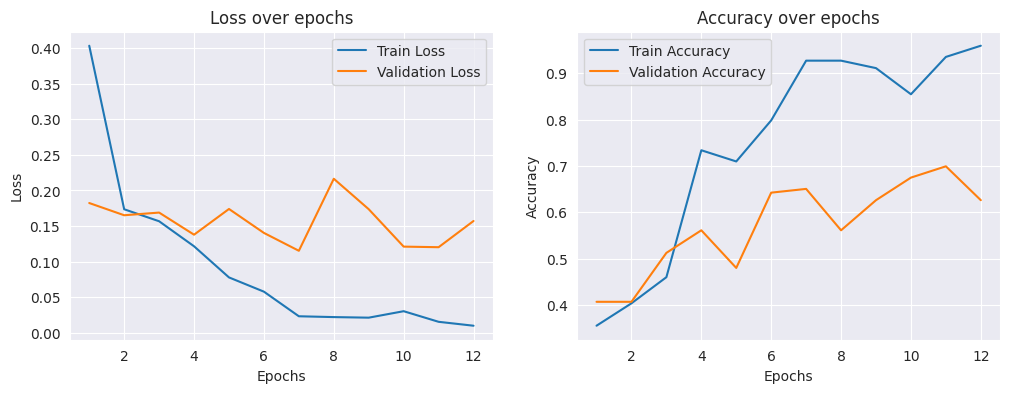

In [11]:
# Plotting function
def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot metrics
plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs)

In [12]:
# Load best model for inference
quant_mobilenetv2_model.load_state_dict(torch.load('best_quant_mobilenetv2_model.pth'))

<All keys matched successfully>

In [13]:
def display_predictions(model, data_loader, class_indices):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    # Create QuantTensor from images
    quant_images = QuantTensor(images, scale=1.0, bit_width=8)

    outputs = model(quant_images)  # Use quantized images
    _, predicted = torch.max(outputs, 1)
    
    # Plot images with predicted labels
    plt.figure(figsize=(15, 10))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        plt.title(f'True: {list(class_indices.keys())[labels[i]]}\nPred: {list(class_indices.keys())[predicted[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


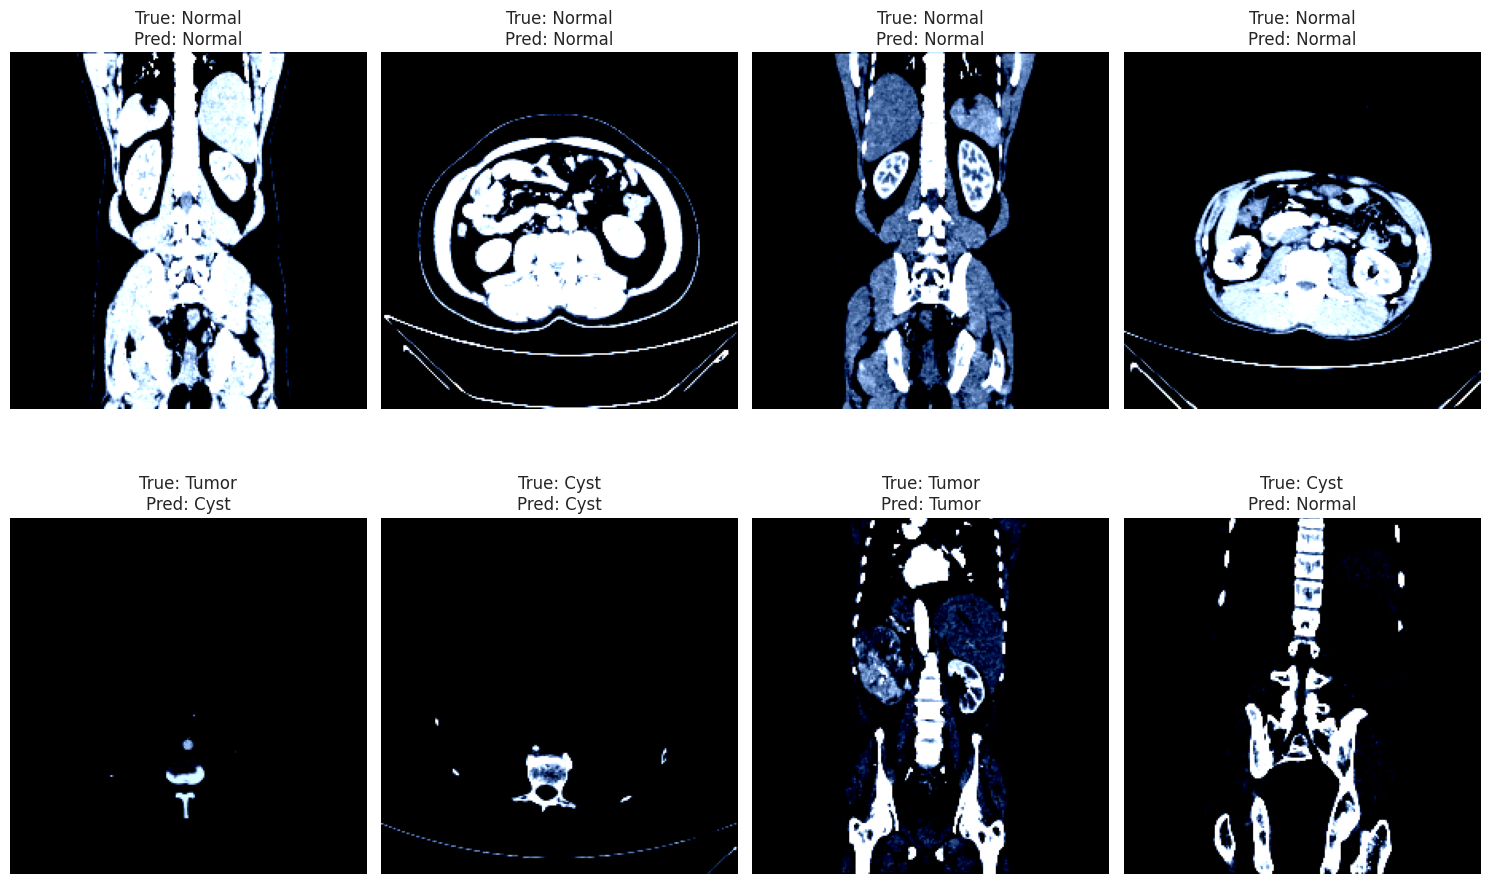

In [14]:
# Display predictions
display_predictions(quant_mobilenetv2_model, test_loader, class_indices)

In [15]:
def evaluate_model(model, test_loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Wrap images in QuantTensor
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)
            outputs = model(quant_images)  # Use quantized images
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    
    return y_true, y_pred, test_loss, test_accuracy

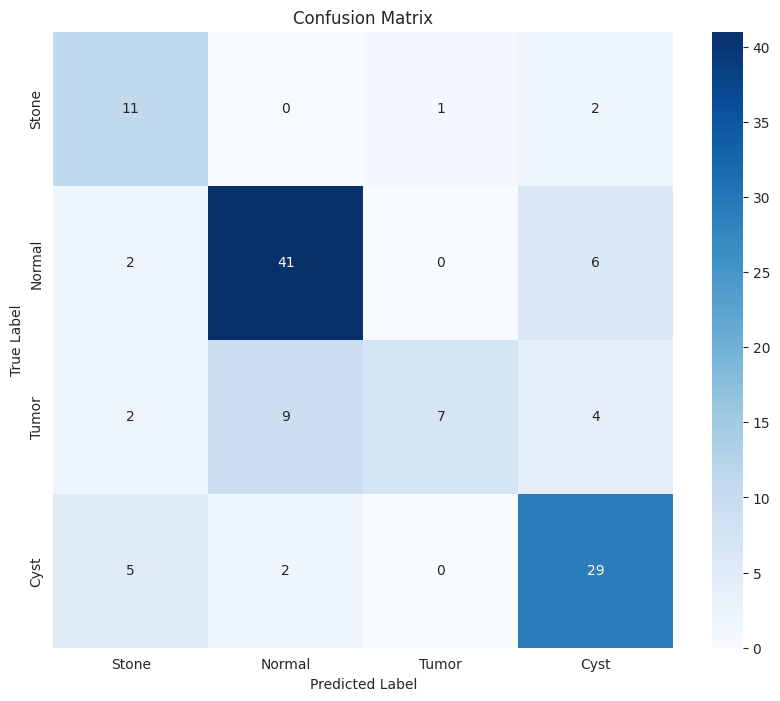

In [16]:
# Evaluate the model and get true and predicted labels
y_true, y_pred, test_loss, test_accuracy = evaluate_model(quant_mobilenetv2_model, test_loader)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=list(class_indices.keys()), columns=list(class_indices.keys()))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from brevitas.quant_tensor import QuantTensor  # Ensure you have this import

# Assuming device is already defined in your previous code
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to preprocess and predict on a single image
def predict_image(image_path, model, transform, class_indices):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Preprocess the image and move to device

    with torch.no_grad():
        # Wrap image in QuantTensor if using quantized model
        quant_image = QuantTensor(image, scale=1.0, bit_width=8)  # Only if using quantized model
        output = model(quant_image)  # Pass quantized image to the model
        probabilities = F.softmax(output, dim=1).cpu().numpy()[0]  # Get probabilities
        predicted_class = np.argmax(probabilities)  # Get predicted class index
        predicted_label = list(class_indices.keys())[predicted_class]  # Get predicted label

    return predicted_label, probabilities




In [18]:
# Define a function to display the prediction results
def display_prediction(image_path, model, transform, class_indices):
    predicted_label, probabilities = predict_image(image_path, model, transform, class_indices)
    
    print(f'Predicted Label: {predicted_label}')
    for label, probability in zip(class_indices.keys(), probabilities):
        print(f'{label}: {probability:.2%}')  # Display probabilities as percentages

    # Display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Prediction: {predicted_label}')
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage: Upload and predict an image
# uploaded_image_path = '/home/vitis/finn/notebooks/pic1.jpg'  # Replace this with the actual image path

# Assuming 'mobilenetv2_model', 'transform', and 'class_indices' are already defined
#display_prediction(uploaded_image_path, quant_mobilenetv2_model, transform, class_indices)

In [19]:
#uploaded_image_path = '/home/vitis/finn/notebooks/pic2s.jpg'  # Replace this with the actual image path
#display_prediction(uploaded_image_path, quant_mobilenetv2_model, transform, class_indices)

In [20]:
#uploaded_image_path = '/home/vitis/finn/notebooks/pic3n.jpg'  # Replace this with the actual image path
#display_prediction(uploaded_image_path, quant_mobilenetv2_model, transform, class_indices)

In [21]:
#uploaded_image_path = '/home/vitis/finn/notebooks/pic4c.jpg'  # Replace this with the actual image path
#display_prediction(uploaded_image_path, quant_mobilenetv2_model, transform, class_indices)

# Step 1: Export the Quantized Model to ONNX

After evaluating the quantized model, we'll export it to ONNX format.

In [22]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

input_shape = (1, 3, 224, 224)

# input is a QuantTensor, so create a random one
# random image, a float from 0 to 1.0
input_a = np.random.randint(0, 1.0, size=input_shape).astype(np.float32)
input_b = torch.from_numpy(input_a)

#input_b = (input_b / input_scale + input_zero_point).clamp(0, 255).to(torch.uint8)

#input_t = QuantTensor(input_b, scale=1.0, zero_point=0.0, bit_width=8, signed=True, training=True)
input_t = QuantTensor(input_b, scale=1.0, zero_point=0.0, bit_width=8, signed=False, training=True)

#Move to CPU before export
quant_mobilenetv2_model.cpu()

finn_model_filename = "finn.onnx"

# Export to ONNX
export_qonnx(quant_mobilenetv2_model, export_path=finn_model_filename, input_t=input_t)

# clean-up
qonnx_cleanup(finn_model_filename, out_file=finn_model_filename)

# ModelWrapper
finn_model = ModelWrapper(finn_model_filename)
finn_model = finn_model.transform(ConvertQONNXtoFINN())
finn_model.save(finn_model_filename)

print("Model saved to %s" % finn_model_filename)

Model saved to finn.onnx


In [23]:
#from finn.util.visualization import showInNetron

#showInNetron(ready_model_filename)

# Step 2: Test the FINN Model

In [24]:
from qonnx.core.datatype import DataType

finnonnx_in_tensor_name = finn_model.graph.input[0].name
finnonnx_out_tensor_name = finn_model.graph.output[0].name
print("Input tensor name: %s" % finnonnx_in_tensor_name)
print("Output tensor name: %s" % finnonnx_out_tensor_name)
finnonnx_model_in_shape = finn_model.get_tensor_shape(finnonnx_in_tensor_name)
finnonnx_model_out_shape = finn_model.get_tensor_shape(finnonnx_out_tensor_name)
print("Input tensor shape: %s" % str(finnonnx_model_in_shape))
print("Output tensor shape: %s" % str(finnonnx_model_out_shape))
finnonnx_model_in_dt = finn_model.get_tensor_datatype(finnonnx_in_tensor_name)
finnonnx_model_out_dt = finn_model.get_tensor_datatype(finnonnx_out_tensor_name)
print("Input tensor datatype: %s" % str(finnonnx_model_in_dt.name))
print("Output tensor datatype: %s" % str(finnonnx_model_out_dt.name))
print("List of node operator types in the graph: ")
print([x.op_type for x in finn_model.graph.node])

Input tensor name: global_in
Output tensor name: global_out
Input tensor shape: [1, 3, 224, 224]
Output tensor shape: [1, 4]
Input tensor datatype: FLOAT32
Output tensor datatype: FLOAT32
List of node operator types in the graph: 
['Conv', 'Mul', 'Add', 'Relu', 'MaxPool', 'Conv', 'Mul', 'Add', 'Relu', 'MaxPool', 'Reshape', 'MatMul', 'Mul', 'Add', 'Relu', 'MatMul', 'Mul', 'Add', 'Relu', 'MatMul', 'Mul', 'Add']


In [25]:
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.fold_constants import FoldConstants

finn_model = finn_model.transform(InferShapes())
finn_model = finn_model.transform(FoldConstants())
finn_model = finn_model.transform(GiveUniqueNodeNames())
finn_model = finn_model.transform(GiveReadableTensorNames())
finn_model = finn_model.transform(InferDataTypes())
finn_model = finn_model.transform(RemoveStaticGraphInputs())

finn_verif_model_filename = "fin_verif.onnx"
finn_model.save(finn_verif_model_filename)

In [26]:
import finn.core.onnx_exec as oxe

def inference_with_finn_onnx(current_inp):
    finnonnx_in_tensor_name = finn_model.graph.input[0].name
    finnonnx_model_in_shape = finn_model.get_tensor_shape(finnonnx_in_tensor_name)
    finnonnx_out_tensor_name = finn_model.graph.output[0].name
    # convert input to numpy for FINN
    current_inp = current_inp.detach().numpy()
    # reshape to expected input (add 1 for batch dimension)
    #current_inp = current_inp.reshape(finnonnx_model_in_shape)
    #print(current_inp.shape)
    # create the input dictionary
    input_dict = {finnonnx_in_tensor_name : current_inp} 
    # run with FINN's execute_onnx
    output_dict = oxe.execute_onnx(finn_model, input_dict)
    #get the output tensor
    finn_output = output_dict[finnonnx_out_tensor_name] 
    return finn_output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


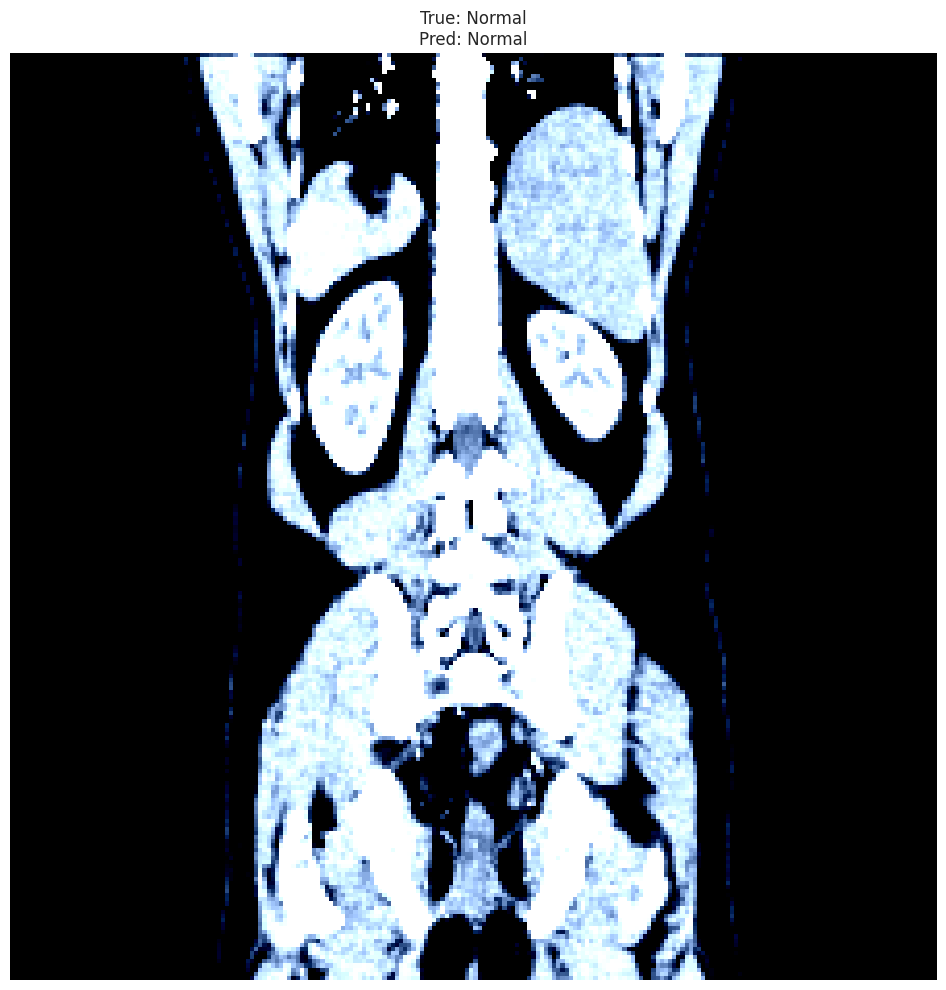

In [27]:
def display_finn_predictions(data_loader, class_indices):
    #model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    outputs = inference_with_finn_onnx(images[0:1])
    outputs = torch.tensor(outputs)
    
    _, predicted = torch.max(outputs, 1)
    
    # Plot images with predicted labels
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 1, 1)
    plt.imshow(images[0].permute(1, 2, 0).cpu())
    plt.title(f'True: {list(class_indices.keys())[labels[0]]}\nPred: {list(class_indices.keys())[predicted[0]]}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

display_finn_predictions(test_loader, class_indices)

In [28]:
# Evaluate the model on the test set
def evaluate_finn_model(test_loader):
    #model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            if images.shape[0] != batch_size:
                continue
            # Wrap images in QuantTensor
            #quant_images = QuantTensor(images, scale=1.0, bit_width=8)
            #outputs = model(quant_images)  # Use quantized images
            outputs = inference_with_finn_onnx(images)
            outputs = torch.tensor(outputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

# Measure metrics during evaluation
#avg_inference_time, throughput, memory_usage = measure_inference_metrics(quant_mobilenetv2_model, test_loader)

# Evaluate the model
test_loss, test_accuracy = evaluate_finn_model(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
#print(f'Average Inference Time: {avg_inference_time:.4f} ms, Throughput: {throughput:.2f} images/s, Memory Usage: {memory_usage:.2f} MB')

Exception: Shape mismatch for provided input global_in: found (1, 3, 224, 224) expected (16, 3, 224, 224) 

## Launch a Build: Only Estimate Reports <a id="build_estimate_report"></a>

In [29]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xc7z020clg400-1",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)

Previous run results deleted!


In [30]:
%%time
build.build_dataflow_cfg(finn_model_filename, cfg_estimates)

Building dataflow accelerator from finn.onnx
Intermediate outputs will be generated in /tmp/finn_dev_emanuel
Final outputs will be generated in output_estimates_only
Build log is at output_estimates_only/build_dataflow.log
Running step: step_qonnx_to_finn [1/10]
Running step: step_tidy_up [2/10]
Running step: step_streamline [3/10]
Running step: step_convert_to_hw [4/10]
Running step: step_create_dataflow_partition [5/10]
Running step: step_specialize_layers [6/10]
Running step: step_target_fps_parallelization [7/10]
Running step: step_apply_folding_config [8/10]
Running step: step_minimize_bit_width [9/10]
Running step: step_generate_estimate_reports [10/10]
Completed successfully
CPU times: user 1.37 s, sys: 57 ms, total: 1.42 s
Wall time: 1.42 s


0

In [31]:
assert os.path.exists(estimates_output_dir + "/report/estimate_network_performance.json")

In [32]:
! ls {estimates_output_dir}

auto_folding_config.json  report
build_dataflow.log	  template_specialize_layers_config.json
intermediate_models	  time_per_step.json


In [33]:
! ls {estimates_output_dir}/report

estimate_layer_config_alternatives.json  estimate_network_performance.json
estimate_layer_cycles.json		 op_and_param_counts.json
estimate_layer_resources.json


In [34]:
! cat {estimates_output_dir}/report/estimate_network_performance.json

{
  "critical_path_cycles": 60500,
  "max_cycles": 60500,
  "max_cycles_node_name": "StreamingMaxPool_hls_0",
  "estimated_throughput_fps": 1652.892561983471,
  "estimated_latency_ns": 605000.0
}

In [35]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

In [36]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

{'StreamingMaxPool_hls_0': 60500}

In [37]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")

{'StreamingMaxPool_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'total': {'BRAM_18K': 0.0, 'LUT': 0.0, 'URAM': 0.0, 'DSP': 0.0}}

In [38]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

rtlsim_output_dir = "output_ipstitch_ooc_rtlsim"

#Delete previous run results if exist
if os.path.exists(rtlsim_output_dir):
    shutil.rmtree(rtlsim_output_dir)
    print("Previous run results deleted!")

cfg_stitched_ip = build.DataflowBuildConfig(
    output_dir          = rtlsim_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xc7z020clg400-1",
    generate_outputs=[
        build_cfg.DataflowOutputType.STITCHED_IP,
        build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
        build_cfg.DataflowOutputType.OOC_SYNTH,
    ]
)

Previous run results deleted!


In [39]:
%%time
build.build_dataflow_cfg(finn_model_filename, cfg_stitched_ip)

Building dataflow accelerator from finn.onnx
Intermediate outputs will be generated in /tmp/finn_dev_emanuel
Final outputs will be generated in output_ipstitch_ooc_rtlsim
Build log is at output_ipstitch_ooc_rtlsim/build_dataflow.log
Running step: step_qonnx_to_finn [1/19]
Running step: step_tidy_up [2/19]
Running step: step_streamline [3/19]
Running step: step_convert_to_hw [4/19]
Running step: step_create_dataflow_partition [5/19]
Running step: step_specialize_layers [6/19]
Running step: step_target_fps_parallelization [7/19]
Running step: step_apply_folding_config [8/19]
Running step: step_minimize_bit_width [9/19]
Running step: step_generate_estimate_reports [10/19]
Running step: step_hw_codegen [11/19]
Running step: step_hw_ipgen [12/19]


multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/emanuel/workspace/finn/src/finn/transformation/fpgadataflow/hlssynth_ip.py", line 72, in applyNodeLocal
    inst.ipgen_singlenode_code()
  File "/home/emanuel/workspace/finn/src/finn/custom_op/fpgadataflow/hlsbackend.py", line 186, in ipgen_singlenode_code
    assert os.path.isdir(ip_path), "IPGen failed: %s not found. Check log under %s" % (
AssertionError: IPGen failed: /tmp/finn_dev_emanuel/code_gen_ipgen_StreamingMaxPool_hls_0_vns_hysq/project_StreamingMaxPool_hls_0/sol1/impl/ip not found. Check log under /tmp/finn_dev_emanuel/code_gen_ipgen_StreamingMaxPool_hls_0_vns_hysq
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last

> /usr/lib/python3.10/multiprocessing/pool.py(774)get()
    772             return self._value
    773         else:
--> 774             raise self._value
    775 
    776     def _set(self, i, obj):

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
Build failed
CPU times: user 1.57 s, sys: 167 ms, total: 1.74 s
Wall time: 19.1 s


-1

In [ ]:
assert os.path.exists(rtlsim_output_dir + "/report/ooc_synth_and_timing.json")
assert os.path.exists(rtlsim_output_dir + "/report/rtlsim_performance.json")
assert os.path.exists(rtlsim_output_dir + "/final_hw_config.json")

In [ ]:
! ls {rtlsim_output_dir}/stitched_ip

In [ ]:
! ls {rtlsim_output_dir}/report

In [ ]:
! cat {rtlsim_output_dir}/report/ooc_synth_and_timing.json

In [ ]:
! cat {rtlsim_output_dir}/report/rtlsim_performance.json

In [ ]:
! cat {rtlsim_output_dir}/final_hw_config.json

In [ ]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = model_dir + "/cybsec-mlp-ready.onnx"

final_output_dir = "output_final"

#Delete previous run results if exist
if os.path.exists(final_output_dir):
    shutil.rmtree(final_output_dir)
    print("Previous run results deleted!")

cfg = build.DataflowBuildConfig(
    output_dir          = final_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    board               = "Pynq-Z1",
    shell_flow_type     = build_cfg.ShellFlowType.VIVADO_ZYNQ,
    generate_outputs=[
        build_cfg.DataflowOutputType.BITFILE,
        build_cfg.DataflowOutputType.PYNQ_DRIVER,
        build_cfg.DataflowOutputType.DEPLOYMENT_PACKAGE,
    ]
)